# Quick Start Guide
This tutorial shows how to use the resampling capabilities in scarlet

In [1]:
# Import Packages and setup
import logging

import numpy as np

import scarlet
import scarlet.display
import astropy.io.fits as fits
from astropy.wcs import WCS
import sep

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

## Load and display the sample data

### Load the sample data and source catalog
Loading the source catalog requires astropy. If you don't have astropy installed you'll have to do the source detection yourself. For example, using `sep`:

```python3
import sep
def makeCatalog(img):
    detect = img.mean(axis=0) # simple average for detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 1.5, err=bkg.globalrms)
    bg_rms = np.array([sep.Background(band).globalrms for band in img])
    return catalog, bg_rms
catalog, bg_rms = makeCatalog(images)
```

Otherwise you can just load the "true" catalog:

In [2]:

def makeCatalog(img):
    if np.size(img.shape) == 3:
        detect = img.mean(axis=0) # simple average for detection
    else:
        detect = img.byteswap().newbyteorder()
        
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 4, err=bkg.globalrms)
    if np.size(img.shape) == 3:
        bg_rms = np.array([sep.Background(band).globalrms for band in img])
    else:
        bg_rms =  sep.Background(detect).globalrms
    return catalog, bg_rms


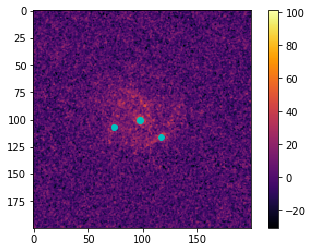

[7.1986804 7.1986804]


In [3]:
# Load the sample images
obs = fits.open('../data/test_resampling/Cut_HSC.fits')
data0_obs = obs[0].data
wcs_obs = WCS(obs[0].header)
psf0_obs = fits.open('../data/test_resampling/PSF_HSC.fits')[0].data

scenehdu = fits.open('../data/test_resampling/Cut_HST.fits')
data0_scene = scenehdu[0].data
wcs_scene = WCS(scenehdu[0].header)
psf0_scene = fits.open('../data/test_resampling/PSF_HST.fits')[0].data


noise = np.concatenate((np.concatenate((data0_scene[0,:], data0_scene[:,0])),
                                            np.concatenate((data0_scene[-1,:], data0_scene[:,-1]))))

psf_obs = psf0_obs[np.newaxis]
psf_obs = np.concatenate((psf_obs, psf_obs))

data_obs = data0_obs[np.newaxis]
data_obs = np.concatenate((data_obs, data_obs))

psf_scene = psf0_scene[np.newaxis]
psf_scene = np.concatenate((psf_scene, psf_scene))

data_scene = data0_scene[np.newaxis]
data_scene = np.concatenate((data_scene, data_scene))

r,N1,N2 = data_obs.shape

catalog, bg_rms = makeCatalog(data_scene)

xo,yo = catalog['x'], catalog['y']

plt.imshow(data_scene[0]); plt.colorbar()
plt.plot(xo,yo, 'oc')
plt.show()
print(bg_rms)

### Display a raw image cube
This is an example of how to display an RGB image from an image cube of multiband data. In this case the image uses a $sin^{-1}$ function to normalize the flux and maps i,r,g (filters 3,2,1) $\rightarrow$ RGB.

## Initialize the sources
Each source is a list of fundamental `scarlet.Component` instances and must be based on `scarlet.Source` or a derived class, in this case `ExtendedSource`, which enforces that the source is monotonic and symmetric.

In [6]:
scene = scarlet.Observation(data_scene, wcs = wcs_scene, psfs = psf_scene)

obs = scarlet.Combination(data_obs, wcs = wcs_obs, psfs = psf_obs)

obs = obs.match(scene)



In [7]:

plt.imshow(obs.diff_psf[0]); plt.show()


x = obs.get_model(data_scene)
print(x.shape)
I = np.zeros(data_obs.shape)
print(np.shape(obs._over_lr))
I[0,obs._over_lr[0], obs._over_lr[1]] = x[0]
plt.imshow(I[0])
plt.show()
sources = [scarlet.Extended_CombinedSource((src['y'],src['x']), scene, obs, bg_rms, symmetric = False, monotonic = False) for src in catalog]

AttributeError: 'Combination' object has no attribute 'diff_psf'

.. warning::

    Note in the code above that coordinates in *scarlet* use the traditional C/numpy notation (y,x) as opposed to the mathematical (x,y) ordering. A common error when first starting out with *scarlet* is to mix the order of x and y in your catalog or source list, which can have adverse affects on the results of the deblender.

## Create and fit the model
The `scarlet.Blend` class represent the sources as a tree and has the machinery to fit all of the sources to the given images. In this example the code is set to run for a maximum of 200 iterations, but will end early if the likelihood and all of the constraints converge.

In [1]:
blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms)
blend.fit(200)
print("scarlet ran for {0} iterations".format(blend.it))

NameError: name 'scarlet' is not defined

## View the results

### View the full model
First we load the model for the entire blend and its residual. Then we display the model using the same $sinh^{-1}$ stretch as the full image and a linear stretch for the residual.

In [ ]:
# Load the model and calculate the residual
model = blend.get_model()
residual = images-model
# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,component in enumerate(blend.components):
    y,x = component.center
    ax[0].text(x, y, k, color="b")
    ax[1].text(x, y, k, color="b")
plt.show()

### View the source models
It can also be useful to view the model for each source. For each source we extract the portion of the image contained in the sources bounding box, the true simulated source flux, and the model of the source, scaled so that all of the images have roughly the same pixel scale.

In [ ]:
def get_true_image(m, catalog, filters):
    """Create the true multiband image for a source
    """
    img = np.array([catalog[m]["intensity_"+f] for f in filters])
    return img

# We can only show the true values if the input catalog has the true intensity data for the sources
# in other words, if you used SEP to build your catalog you do not have the true data.
if "intensity_"+filters[0] in catalog.colnames:
    has_truth = True
    axes = 3
else:
    has_truth = False
    axes = 2

for k,src in enumerate(blend.components):
    # Get the model for a single source
    model = blend.get_model(k=k)[src.bb]
    _rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
    # Get the patch from the original image
    _img = images[src.bb]
    _img_rgb = scarlet.display.img_to_rgb(_img, filter_indices=filter_indices, norm=norm)
    # Set the figure size
    ratio = src.shape[2]/src.shape[1]
    fig_height = 3*src.shape[1]/20
    fig_width = max(3*fig_height*ratio,2)
    fig = plt.figure(figsize=(fig_width, fig_height))
    # Generate and show the figure
    ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
    ax[0].imshow(_img_rgb)
    ax[0].set_title("Data")
    ax[1].imshow(_rgb)
    ax[1].set_title("model {0}".format(k))
    if has_truth:
        # Get the true image for the same source
        truth = get_true_image(k, catalog, filters)[src.bb]
        true_rgb = scarlet.display.img_to_rgb(truth, filter_indices=filter_indices, norm=norm)
        ax[2].imshow(true_rgb)
        ax[2].set_title("truth")
    plt.show()